In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

# Data Collection


***

## Epidemiological Data

RKI (COVID-19-Hospitalisierungen, amelag_einzelstandorte(sewage monitoring), ARE-Konsultationsinzidenz, COVID-ARE-Konsultationsinzidenz, GrippeWeb_Daten_des_Wochenberichts, IfSG_Influenzafaelle, Intensivregister_Bundeslaender_Kapazitaeten, Notaufnahmesurveillance_Zeitreihen_Syndrome, SARI-Hospitalisierungsinzidenz)

***
### Covid19 hospitlisations

In [97]:
df_c19hosp_orig = pd.read_csv('../data/Aktuell_Deutschland_COVID-19-Hospitalisierungen.csv')
df_c19hosp_orig

,Datum,Bundesland,Bundesland_Id,Altersgruppe,7T_Hospitalisierung_Faelle,7T_Hospitalisierung_Inzidenz
0,2025-05-22,Bundesgebiet,0,00-04,10,0.25
1,2025-05-22,Bundesgebiet,0,00+,159,0.19
2,2025-05-22,Bundesgebiet,0,05-14,0,0.00
3,2025-05-22,Bundesgebiet,0,15-34,8,0.04
4,2025-05-22,Bundesgebiet,0,35-59,15,0.05
...,...,...,...,...,...,...
227166,2020-03-01,Thüringen,16,05-14,0,0.00
227167,2020-03-01,Thüringen,16,15-34,0,0.00
227168,2020-03-01,Thüringen,16,35-59,0,0.00
227169,2020-03-01,Thüringen,16,60-79,0,0.00


In [98]:
df_c19hosp_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227171 entries, 0 to 227170
Data columns (total 6 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Datum                         227171 non-null  object 
 1   Bundesland                    227171 non-null  object 
 2   Bundesland_Id                 227171 non-null  int64  
 3   Altersgruppe                  227171 non-null  object 
 4   7T_Hospitalisierung_Faelle    227171 non-null  int64  
 5   7T_Hospitalisierung_Inzidenz  227171 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 10.4+ MB


In [99]:
df_c19hosp_orig.nunique()

Datum                           1909
Bundesland                        17
Bundesland_Id                     17
Altersgruppe                       7
7T_Hospitalisierung_Faelle      4082
7T_Hospitalisierung_Inzidenz    6431
dtype: int64

In [100]:
df_c19hosp = df_c19hosp_orig[df_c19hosp_orig['Bundesland'] != 'Bundesgebiet'].copy()

In [101]:
df_c19hosp.drop(columns=['Bundesland_Id'], inplace=True)

In [102]:
df_c19hosp['date'] = pd.to_datetime(df_c19hosp['Datum'])
df_c19hosp['year'] = df_c19hosp['date'].dt.year
df_c19hosp['month'] = df_c19hosp['date'].dt.month
df_c19hosp['day'] = df_c19hosp['date'].dt.day
df_c19hosp['day_of_year'] = df_c19hosp['date'].dt.dayofyear
df_c19hosp['week_of_year'] = df_c19hosp['date'].dt.isocalendar().week.astype(int)
df_c19hosp['day_of_week'] = df_c19hosp['date'].dt.dayofweek

In [103]:
df_c19hosp

,Datum,Bundesland,Altersgruppe,7T_Hospitalisierung_Faelle,7T_Hospitalisierung_Inzidenz,date,year,month,day,day_of_year,week_of_year,day_of_week
7,2025-05-22,Schleswig-Holstein,00-04,0,0.0,2025-05-22,2025,5,22,142,21,3
8,2025-05-22,Schleswig-Holstein,00+,6,0.2,2025-05-22,2025,5,22,142,21,3
9,2025-05-22,Schleswig-Holstein,05-14,0,0.0,2025-05-22,2025,5,22,142,21,3
10,2025-05-22,Schleswig-Holstein,15-34,0,0.0,2025-05-22,2025,5,22,142,21,3
11,2025-05-22,Schleswig-Holstein,35-59,0,0.0,2025-05-22,2025,5,22,142,21,3
...,...,...,...,...,...,...,...,...,...,...,...,...
227166,2020-03-01,Thüringen,05-14,0,0.0,2020-03-01,2020,3,1,61,9,6
227167,2020-03-01,Thüringen,15-34,0,0.0,2020-03-01,2020,3,1,61,9,6
227168,2020-03-01,Thüringen,35-59,0,0.0,2020-03-01,2020,3,1,61,9,6
227169,2020-03-01,Thüringen,60-79,0,0.0,2020-03-01,2020,3,1,61,9,6


***
### sewage monitoring

SARS-CoV2 monitoring is considrably tighter than Infleuzna and RSV. Therefore the latter will be aggregated more heavily.

In [104]:
df_sewage_orig = pd.read_csv('../data/amelag_einzelstandorte.tsv', sep='\t')
df_sewage_orig

,standort,bundesland,datum,viruslast,loess_vorhersage,loess_obere_schranke,loess_untere_schranke,einwohner,laborwechsel,normalisierung,typ,unter_bg
0,Aachen,NW,2024-08-07,250.0,263.14,499.10,138.73,206424,nein,nein,Influenza A,ja
1,Aachen,NW,2024-08-08,NaN,262.36,487.32,141.24,206424,nein,NaN,Influenza A,NaN
2,Aachen,NW,2024-08-09,NaN,261.59,476.11,143.72,206424,nein,NaN,Influenza A,NaN
3,Aachen,NW,2024-08-10,NaN,260.83,465.43,146.17,206424,nein,NaN,Influenza A,NaN
4,Aachen,NW,2024-08-11,NaN,260.08,455.26,148.57,206424,nein,NaN,Influenza A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
267821,Zweibrücken,RP,2024-12-14,NaN,59064.02,112816.23,30922.49,36498,nein,NaN,SARS-CoV-2,NaN
267822,Zweibrücken,RP,2024-12-15,NaN,58124.40,112910.27,29921.51,36498,nein,NaN,SARS-CoV-2,NaN
267823,Zweibrücken,RP,2024-12-16,38400.0,57196.04,113044.10,28939.04,36498,nein,ja,SARS-CoV-2,nein
267824,Zweibrücken,RP,2024-12-17,NaN,56278.98,113217.64,27975.53,36498,nein,NaN,SARS-CoV-2,NaN


In [105]:
df_sewage = df_sewage_orig.drop(columns=['einwohner', 'laborwechsel', 'normalisierung', 'unter_bg']).copy()

df_sewage['datum'] = pd.to_datetime(df_sewage['datum'])
df_sewage

,standort,bundesland,datum,viruslast,loess_vorhersage,loess_obere_schranke,loess_untere_schranke,typ
0,Aachen,NW,2024-08-07,250.0,263.14,499.10,138.73,Influenza A
1,Aachen,NW,2024-08-08,NaN,262.36,487.32,141.24,Influenza A
2,Aachen,NW,2024-08-09,NaN,261.59,476.11,143.72,Influenza A
3,Aachen,NW,2024-08-10,NaN,260.83,465.43,146.17,Influenza A
4,Aachen,NW,2024-08-11,NaN,260.08,455.26,148.57,Influenza A
...,...,...,...,...,...,...,...,...
267821,Zweibrücken,RP,2024-12-14,NaN,59064.02,112816.23,30922.49,SARS-CoV-2
267822,Zweibrücken,RP,2024-12-15,NaN,58124.40,112910.27,29921.51,SARS-CoV-2
267823,Zweibrücken,RP,2024-12-16,38400.0,57196.04,113044.10,28939.04,SARS-CoV-2
267824,Zweibrücken,RP,2024-12-17,NaN,56278.98,113217.64,27975.53,SARS-CoV-2


#### sars-cov 2

In [106]:
df_sc2 = df_sewage[df_sewage['typ'] == 'SARS-CoV-2'].copy()

df_sc2['year'] = df_sc2['datum'].dt.year
df_sc2['month'] = df_sc2['datum'].dt.month
df_sc2['day_of_week'] = df_sc2['datum'].dt.dayofweek
df_sc2['day_of_year'] = df_sc2['datum'].dt.dayofyear
df_sc2['week_of_year'] = df_sc2['datum'].dt.isocalendar().week.astype(int)

df_sc2


,standort,bundesland,datum,viruslast,loess_vorhersage,loess_obere_schranke,loess_untere_schranke,typ,year,month,day_of_week,day_of_year,week_of_year
1476,Aachen,NW,2021-11-24,37400.0,14876.24,30953.11,7149.60,SARS-CoV-2,2021,11,2,328,47
1477,Aachen,NW,2021-11-25,NaN,15774.27,32198.05,7728.03,SARS-CoV-2,2021,11,3,329,47
1478,Aachen,NW,2021-11-26,NaN,16715.92,33486.07,8344.42,SARS-CoV-2,2021,11,4,330,47
1479,Aachen,NW,2021-11-27,NaN,17702.50,34818.30,9000.39,SARS-CoV-2,2021,11,5,331,47
1480,Aachen,NW,2021-11-28,NaN,18735.33,36195.90,9697.57,SARS-CoV-2,2021,11,6,332,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267821,Zweibrücken,RP,2024-12-14,NaN,59064.02,112816.23,30922.49,SARS-CoV-2,2024,12,5,349,50
267822,Zweibrücken,RP,2024-12-15,NaN,58124.40,112910.27,29921.51,SARS-CoV-2,2024,12,6,350,50
267823,Zweibrücken,RP,2024-12-16,38400.0,57196.04,113044.10,28939.04,SARS-CoV-2,2024,12,0,351,51
267824,Zweibrücken,RP,2024-12-17,NaN,56278.98,113217.64,27975.53,SARS-CoV-2,2024,12,1,352,51


In [107]:
value_cols = ['viruslast', 'loess_vorhersage', 'loess_obere_schranke', 'loess_untere_schranke']

groupby_cols = [
    'bundesland', 'datum', 'year', 'month', 'day_of_week',
    'day_of_year', 'week_of_year'
]

df_sc2_agg = df_sc2.groupby(groupby_cols)[value_cols].median().reset_index()

df_sc2_agg.rename(columns={col: f'{col}_sarscov2' for col in value_cols}, inplace=True)

df_sc2_agg

,bundesland,datum,year,month,day_of_week,day_of_year,week_of_year,viruslast_sarscov2,loess_vorhersage_sarscov2,loess_obere_schranke_sarscov2,loess_untere_schranke_sarscov2
0,BB,2022-06-13,2022,6,0,164,24,65000.0,81413.53,197042.90,33638.18
1,BB,2022-06-14,2022,6,1,165,24,NaN,83361.41,195184.45,35602.86
2,BB,2022-06-15,2022,6,2,166,24,NaN,85252.57,193305.28,37598.57
3,BB,2022-06-16,2022,6,3,167,24,NaN,87082.00,191408.53,39618.27
4,BB,2022-06-17,2022,6,4,168,24,NaN,88844.88,189497.43,41654.46
...,...,...,...,...,...,...,...,...,...,...,...
17641,TH,2025-05-10,2025,5,5,130,19,NaN,15322.25,24721.47,9496.65
17642,TH,2025-05-11,2025,5,6,131,19,19000.0,15252.71,25227.98,9221.71
17643,TH,2025-05-12,2025,5,0,132,20,15530.0,15187.82,25788.14,8944.81
17644,TH,2025-05-13,2025,5,1,133,20,NaN,15127.75,26404.75,8666.96


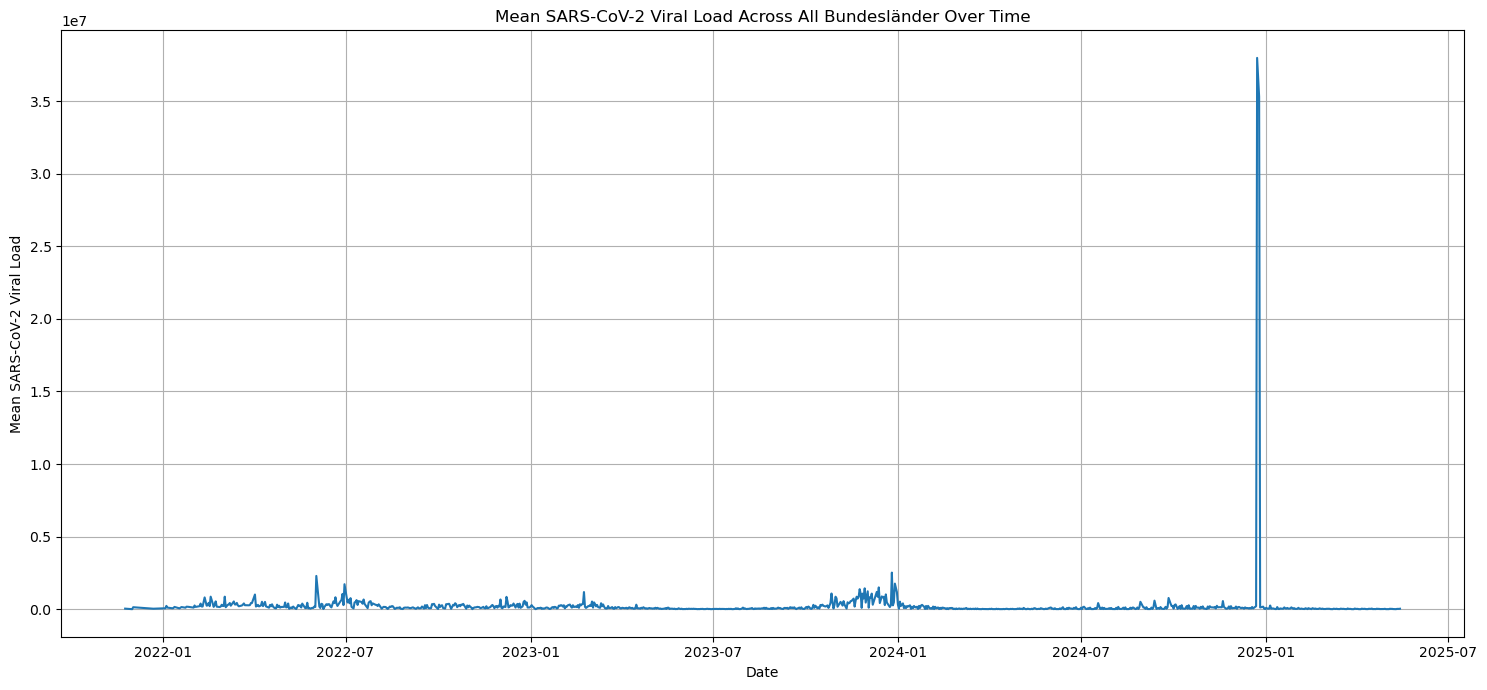

In [108]:
df_median_viruslast_over_time = df_sc2_agg.groupby('datum')['viruslast_sarscov2'].median().reset_index()

# Plotting
plt.figure(figsize=(15, 7))
sns.lineplot(x='datum', y='viruslast_sarscov2', data=df_median_viruslast_over_time)
plt.title('Mean SARS-CoV-2 Viral Load Across All Bundesländer Over Time')
plt.xlabel('Date')
plt.ylabel('Mean SARS-CoV-2 Viral Load')
plt.grid(True)
plt.tight_layout()
plt.show()

In [109]:
threshold = 1 * 1e7
df_sc2_filt = df_sc2_agg.copy()
df_sc2_filt['viruslast_sarscov2'] = df_sc2_filt['viruslast_sarscov2'].apply(
    lambda x: np.nan if x > threshold else x
)

In [110]:
df_sc2_filt

,bundesland,datum,year,month,day_of_week,day_of_year,week_of_year,viruslast_sarscov2,loess_vorhersage_sarscov2,loess_obere_schranke_sarscov2,loess_untere_schranke_sarscov2
0,BB,2022-06-13,2022,6,0,164,24,65000.0,81413.53,197042.90,33638.18
1,BB,2022-06-14,2022,6,1,165,24,NaN,83361.41,195184.45,35602.86
2,BB,2022-06-15,2022,6,2,166,24,NaN,85252.57,193305.28,37598.57
3,BB,2022-06-16,2022,6,3,167,24,NaN,87082.00,191408.53,39618.27
4,BB,2022-06-17,2022,6,4,168,24,NaN,88844.88,189497.43,41654.46
...,...,...,...,...,...,...,...,...,...,...,...
17641,TH,2025-05-10,2025,5,5,130,19,NaN,15322.25,24721.47,9496.65
17642,TH,2025-05-11,2025,5,6,131,19,19000.0,15252.71,25227.98,9221.71
17643,TH,2025-05-12,2025,5,0,132,20,15530.0,15187.82,25788.14,8944.81
17644,TH,2025-05-13,2025,5,1,133,20,NaN,15127.75,26404.75,8666.96


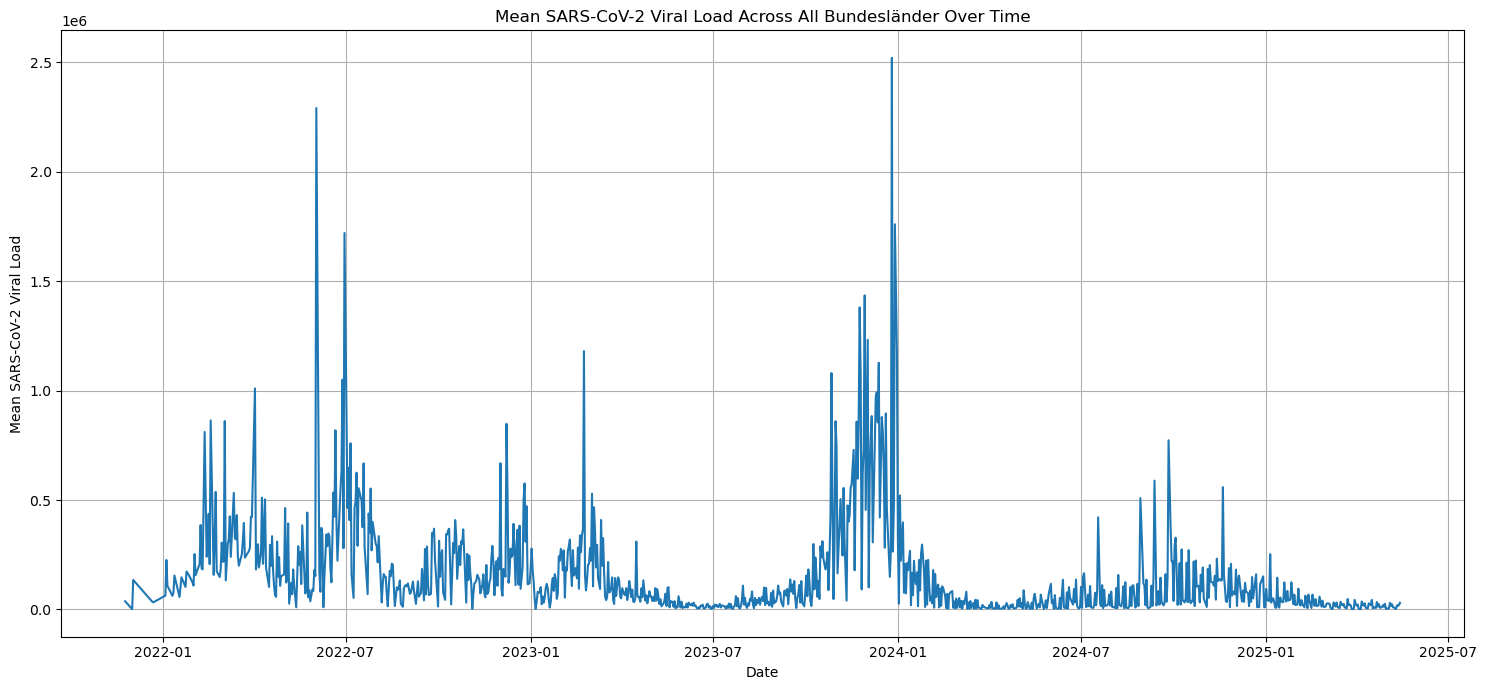

In [111]:
df_median_viruslast_over_time_2 = df_sc2_filt.groupby('datum')['viruslast_sarscov2'].median().reset_index()

# Plotting
plt.figure(figsize=(15, 7))
sns.lineplot(x='datum', y='viruslast_sarscov2', data=df_median_viruslast_over_time_2)
plt.title('Mean SARS-CoV-2 Viral Load Across All Bundesländer Over Time')
plt.xlabel('Date')
plt.ylabel('Mean SARS-CoV-2 Viral Load')
plt.grid(True)
plt.tight_layout()
plt.show()

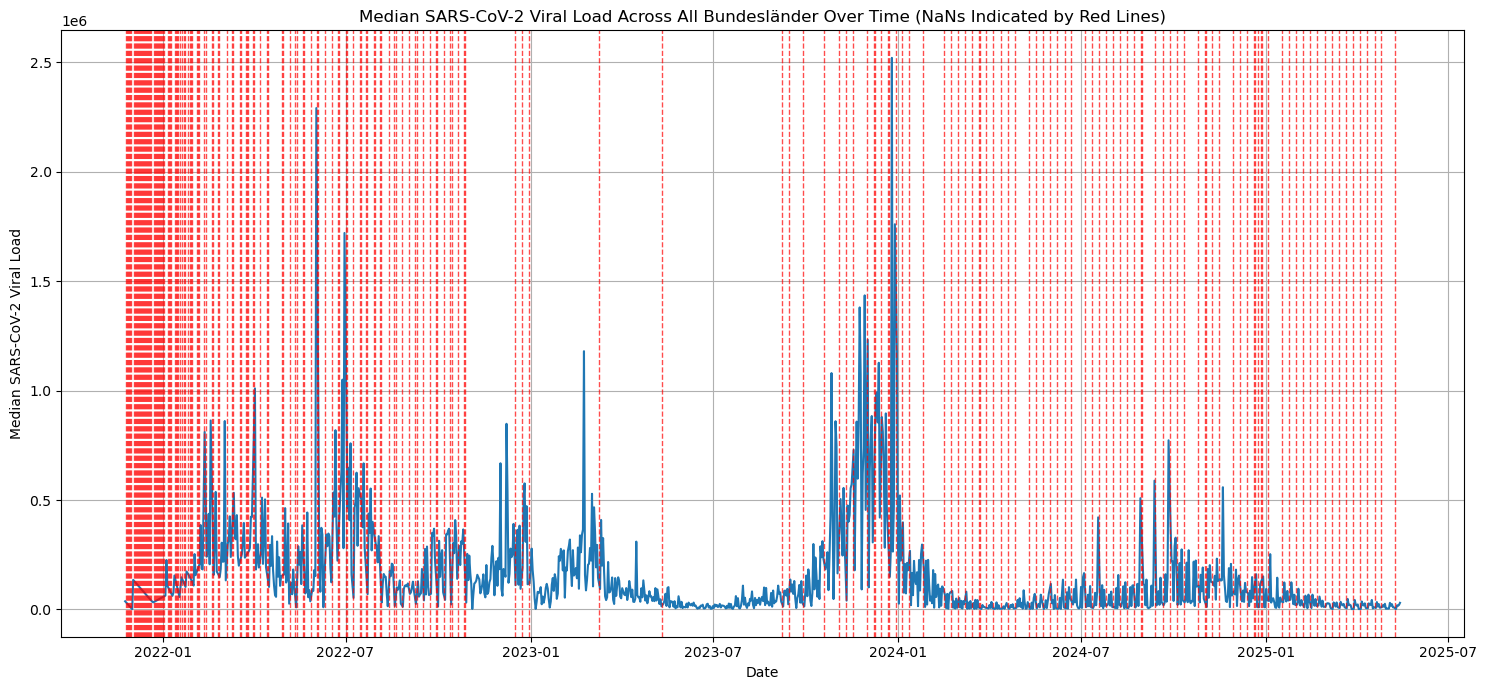

Number of dates with NaN median viral load: 201


In [112]:
df_median_viruslast_over_time_2 = df_sc2_filt.groupby('datum')['viruslast_sarscov2'].median().reset_index()

nan_dates = df_median_viruslast_over_time_2[df_median_viruslast_over_time_2['viruslast_sarscov2'].isnull()]['datum']


plt.figure(figsize=(15, 7))

sns.lineplot(x='datum', y='viruslast_sarscov2', data=df_median_viruslast_over_time_2)

for date in nan_dates:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.title('Median SARS-CoV-2 Viral Load Across All Bundesländer Over Time (NaNs Indicated by Red Lines)')
plt.xlabel('Date')
plt.ylabel('Median SARS-CoV-2 Viral Load')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Number of dates with NaN median viral load: {len(nan_dates)}")

In [121]:
df_sc2_fill = df_sc2_filt.copy()

df_sc2_fill.sort_values(by=['bundesland', 'datum'], inplace=True)

df_sc2_fill['viruslast_sarscov2'] = df_sc2_fill.groupby('bundesland')['viruslast_sarscov2'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both', limit_area='inside')
)

df_sc2_fill['viruslast_sarscov2'] = df_sc2_fill.groupby('bundesland')['viruslast_sarscov2'].transform(
    lambda x: x.ffill().bfill()
)

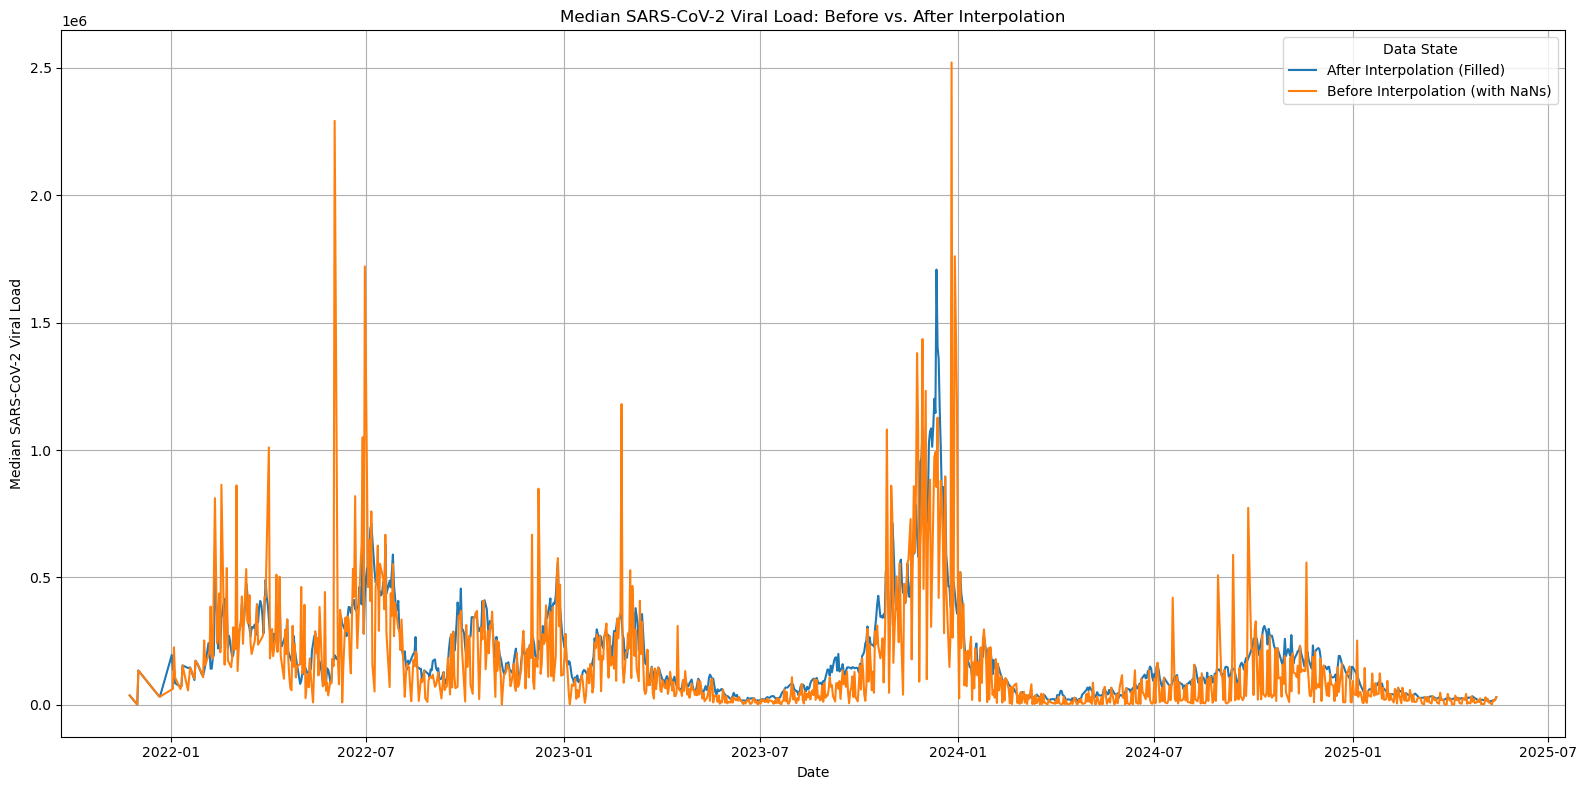

In [122]:
# 1. Calculate median viral load over time for df_sc2_filt (before fill)
df_median_before_fill = df_sc2_filt.groupby('datum')['viruslast_sarscov2'].median().reset_index()
df_median_before_fill.rename(columns={'viruslast_sarscov2': 'median_viral_load'}, inplace=True)
df_median_before_fill['Data_Type'] = 'Before Interpolation (with NaNs)'

# 2. Calculate median viral load over time for df_sc2_fill (after fill)
df_median_after_fill = df_sc2_fill.groupby('datum')['viruslast_sarscov2'].median().reset_index()
df_median_after_fill.rename(columns={'viruslast_sarscov2': 'median_viral_load'}, inplace=True)
df_median_after_fill['Data_Type'] = 'After Interpolation (Filled)'

# Combine for easier plotting with Seaborn
# Key change: Reset the index *after* concatenation
df_plot_combined = pd.concat([df_median_before_fill, df_median_after_fill]).reset_index(drop=True)

# Ensure datum is sorted in the combined DataFrame, which is generally good practice for time series plots
df_plot_combined.sort_values(by=['datum', 'Data_Type'], inplace=True)


# Plotting
plt.figure(figsize=(16, 8))
sns.lineplot(
    x='datum',
    y='median_viral_load',
    hue='Data_Type',
    data=df_plot_combined,
    lw=1.5, # Line width
    errorbar=None # Explicitly disable error bars (still good practice with this data)
)

plt.title('Median SARS-CoV-2 Viral Load: Before vs. After Interpolation')
plt.xlabel('Date')
plt.ylabel('Median SARS-CoV-2 Viral Load')
plt.grid(True)
plt.legend(title='Data State')
plt.tight_layout()
plt.show()

In [ ]:
columns_to_interpolate_loess = [
    'loess_vorhersage_sarscov2',
    'loess_obere_schranke_sarscov2',
    'loess_untere_schranke_sarscov2'
]

for col in columns_to_interpolate_loess:
    df_sc2_fill[col] = df_sc2_fill.groupby('bundesland')[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both', limit_area='inside')
    )
    df_sc2_fill[col] = df_sc2_fill.groupby('bundesland')[col].transform(
        lambda x: x.ffill().bfill()
    )


#### IA/BV and RSV

In [127]:
def assign_viral_group(typ):
    if 'Influenza' in typ:
        return 'Influenza (All Types)'
    elif 'RSV' in typ:
        return 'RSV (All Types)'
    elif 'SARS-CoV-2' in typ:
        return 'SARS-CoV-2'
    else:
        return 'Other'

df_sewage['viral_group'] = df_sewage['typ'].apply(assign_viral_group)


# Check the minimum date for Influenza (All Types)
influenza_min_date = df_sewage[df_sewage['viral_group'] == 'Influenza (All Types)']['datum'].min()
print(f"Earliest date for Influenza (All Types): {influenza_min_date}")

# Check the minimum date for RSV (All Types)
rsv_min_date = df_sewage[df_sewage['viral_group'] == 'RSV (All Types)']['datum'].min()
print(f"Earliest date for RSV (All Types): {rsv_min_date}")

Earliest date for Influenza (All Types): 2023-10-18 00:00:00
Earliest date for RSV (All Types): 2024-01-03 00:00:00



Visualizing weekly data availability for: Influenza (All Types)


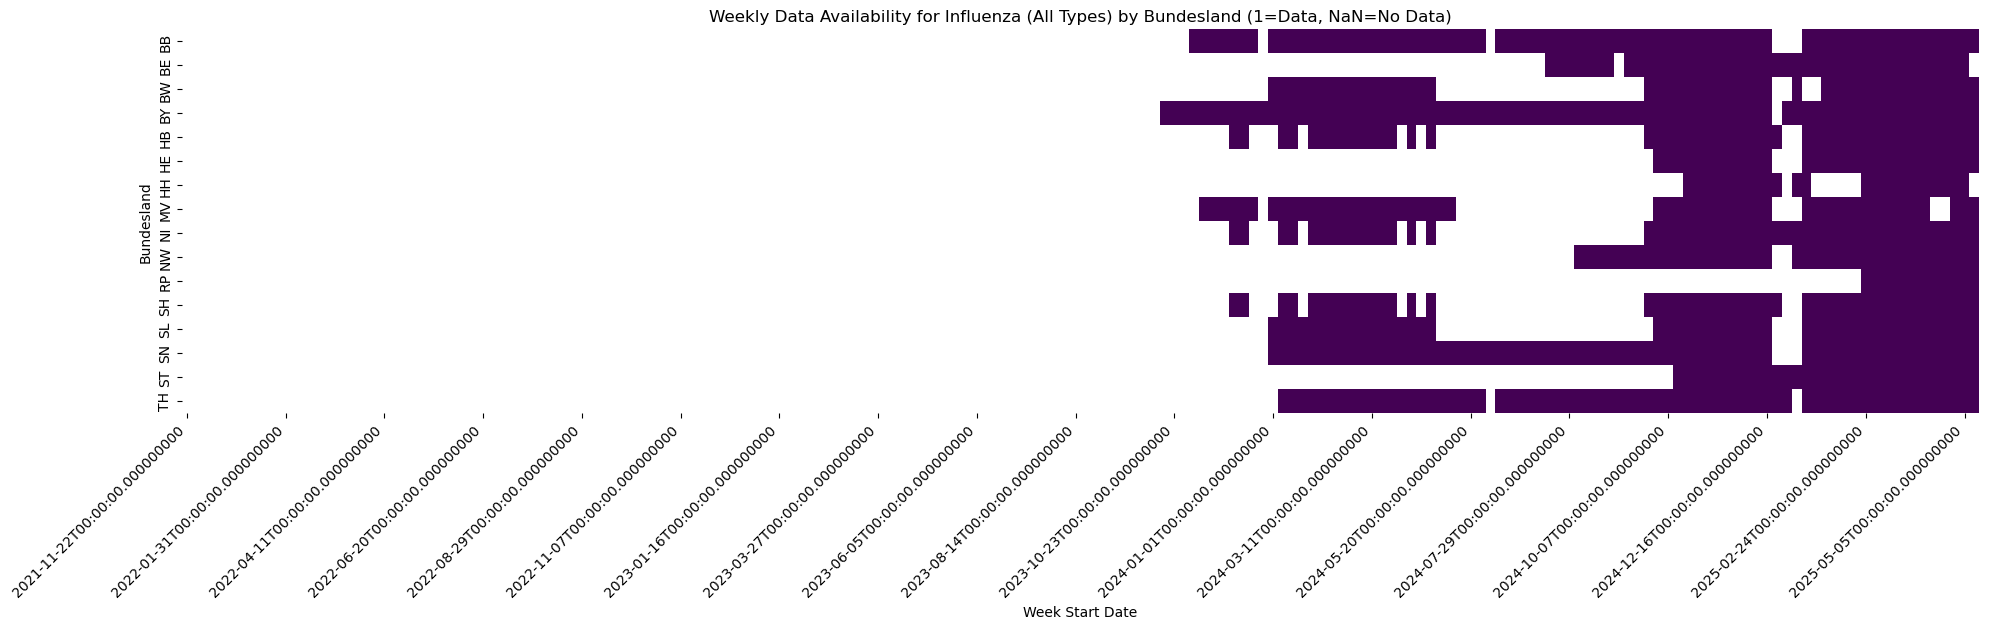

Total weekly aggregated entries for Influenza (All Types): 803
Number of unique Bundesländer for Influenza (All Types): 16
Weekly date range for Influenza (All Types): 2023-10-16 to 2025-05-12

Visualizing weekly data availability for: RSV (All Types)


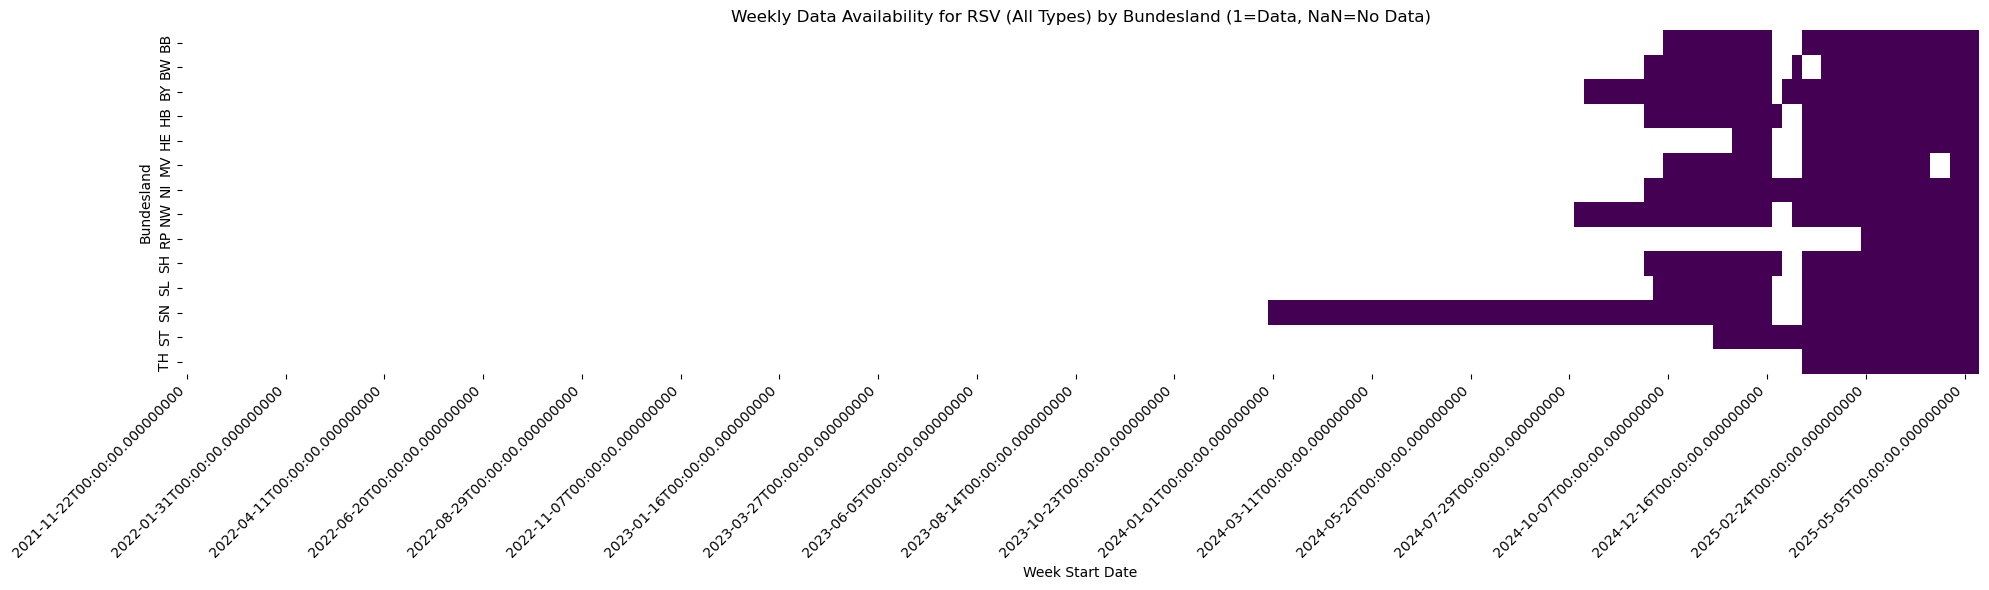

Total weekly aggregated entries for RSV (All Types): 457
Number of unique Bundesländer for RSV (All Types): 14
Weekly date range for RSV (All Types): 2024-01-01 to 2025-05-12


In [130]:
# Re-defining the combined virus groups we want to focus on (excluding SARS-CoV-2)
combined_other_virus_types = [
    'Influenza (All Types)',
    'RSV (All Types)'
]

# 1. Ensure 'week_start_date' is available in df_sewage
# This sets the date to the Monday of the week for grouping
df_sewage['week_start_date'] = df_sewage['datum'].dt.to_period('W').dt.start_time

# 2. Define the columns to aggregate and the grouping keys for weekly data
value_cols = ['viruslast', 'loess_vorhersage', 'loess_obere_schranke', 'loess_untere_schranke']
groupby_cols_weekly = ['bundesland', 'viral_group', 'week_start_date']

# 3. Perform weekly aggregation for ALL viral groups, then filter later
df_sewage_weekly_agg = df_sewage.groupby(groupby_cols_weekly)[value_cols].median().reset_index()

# Rename columns for clarity, similar to df_sc2_agg
df_sewage_weekly_agg.rename(columns={col: f'{col}_weekly' for col in value_cols}, inplace=True)


# --- Visualization of Data Availability on a Weekly Basis (ONLY for Influenza and RSV) ---

for virus_group in combined_other_virus_types: # Loop only through Influenza and RSV
    print(f"\nVisualizing weekly data availability for: {virus_group}")

    # Filter data for the current combined virus group
    df_group_weekly = df_sewage_weekly_agg[df_sewage_weekly_agg['viral_group'] == virus_group].copy()

    # Create a pivot table to show data presence (1) or absence (NaN/0)
    data_presence_weekly_pivot = df_group_weekly.pivot_table(
        index='bundesland',
        columns='week_start_date',
        values='viruslast_weekly',
        aggfunc=lambda x: 1 if x.notna().any() else 0 # Mark 1 if any viruslast_weekly value exists
    ).fillna(0)

    # Get the full range of week_start_dates for consistent heatmap columns
    # Use the full range from the entire df_sewage_weekly_agg to ensure consistent x-axis for comparison
    min_date_all_groups = df_sewage_weekly_agg['week_start_date'].min()
    max_date_all_groups = df_sewage_weekly_agg['week_start_date'].max()
    all_week_dates = pd.date_range(start=min_date_all_groups,
                                   end=max_date_all_groups,
                                   freq='W-MON').normalize() # Normalize to Monday for consistency
    data_presence_reindexed_weekly = data_presence_weekly_pivot.reindex(columns=all_week_dates, fill_value=0)


    # Prepare for heatmap: Replace 0 with NaN for visual gaps, 1 for data presence
    data_presence_for_plot_weekly = data_presence_reindexed_weekly.replace(0, np.nan)

    # Plotting the heatmap
    plt.figure(figsize=(20, max(6, len(data_presence_for_plot_weekly.index) * 0.4)))
    sns.heatmap(
        data_presence_for_plot_weekly,
        cmap='viridis',
        cbar=False,
        yticklabels=True,
        xticklabels=10
    )
    plt.title(f'Weekly Data Availability for {virus_group} by Bundesland (1=Data, NaN=No Data)')
    plt.xlabel('Week Start Date')
    plt.ylabel('Bundesland')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"Total weekly aggregated entries for {virus_group}: {len(df_group_weekly)}")
    print(f"Number of unique Bundesländer for {virus_group}: {df_group_weekly['bundesland'].nunique()}")
    print(f"Weekly date range for {virus_group}: {df_group_weekly['week_start_date'].min().strftime('%Y-%m-%d')} to {df_group_weekly['week_start_date'].max().strftime('%Y-%m-%d')}")

***
### ARE konsultationsinzidenz

In [59]:
df_arekonsul_orig = pd.read_csv('../data/ARE-Konsultationsinzidenz.tsv', sep='\t')

In [60]:
df_arekonsul_orig.drop(columns=["Saison", "Bundesland_ID"], inplace=False)

,Kalenderwoche,Bundesland,Altersgruppe,ARE_Konsultationsinzidenz
0,2012-W40,Bundesweit,00+,970
1,2012-W40,Bundesweit,0-4,3882
2,2012-W40,Bundesweit,5-14,1378
3,2012-W40,Bundesweit,15-34,1211
4,2012-W40,Bundesweit,60+,408
...,...,...,...,...
17101,2025-W20,Thueringen,0-4,4797
17102,2025-W20,Thueringen,5-14,1964
17103,2025-W20,Thueringen,15-34,1145
17104,2025-W20,Thueringen,60+,438


In [61]:
df_agegrps = df_arekonsul_orig.pivot_table(
    index=["Kalenderwoche", "Bundesland"],
    columns='Altersgruppe',
    values="ARE_Konsultationsinzidenz"
).reset_index()
df_agegrps.columns = [f"ARE_konsul_{col}" if col != 'Kalenderwoche' and col != 'Bundesland' else col for col in df_agegrps.columns]

df_agegrps = df_agegrps[df_agegrps["Kalenderwoche"].str[:4].astype(int) >= 2022]

In [63]:
df_daily = df_agegrps.copy()

df_daily['Kalenderwoche'] = pd.to_datetime(df_daily['Kalenderwoche'].apply(lambda x: f'{x[:4]}-{x[5:]}-1'), format='%G-W%V-%u')

# writes all days of the week into a new date column and inserts new rows by exploding
df_daily['Date'] = df_daily.apply(lambda row: pd.date_range(row['Kalenderwoche'], row['Kalenderwoche'] + pd.Timedelta(days=6)), axis=1)
df_daily = df_daily.explode('Date')

# added rows keep the index of the row from which they exploded from. grp'ed by them we fill in nans instead of copying values
cols_to_nan = [col for col in df_daily.columns if col not in ['Date', 'Bundesland']]
df_daily[cols_to_nan] = df_daily.groupby(level=0)[cols_to_nan].transform(lambda x: [x.iloc[0]] + [np.nan]*(len(x)-1))

df_daily.drop(columns=['Kalenderwoche'], inplace=True)  

df_daily = df_daily.reset_index(drop=True)


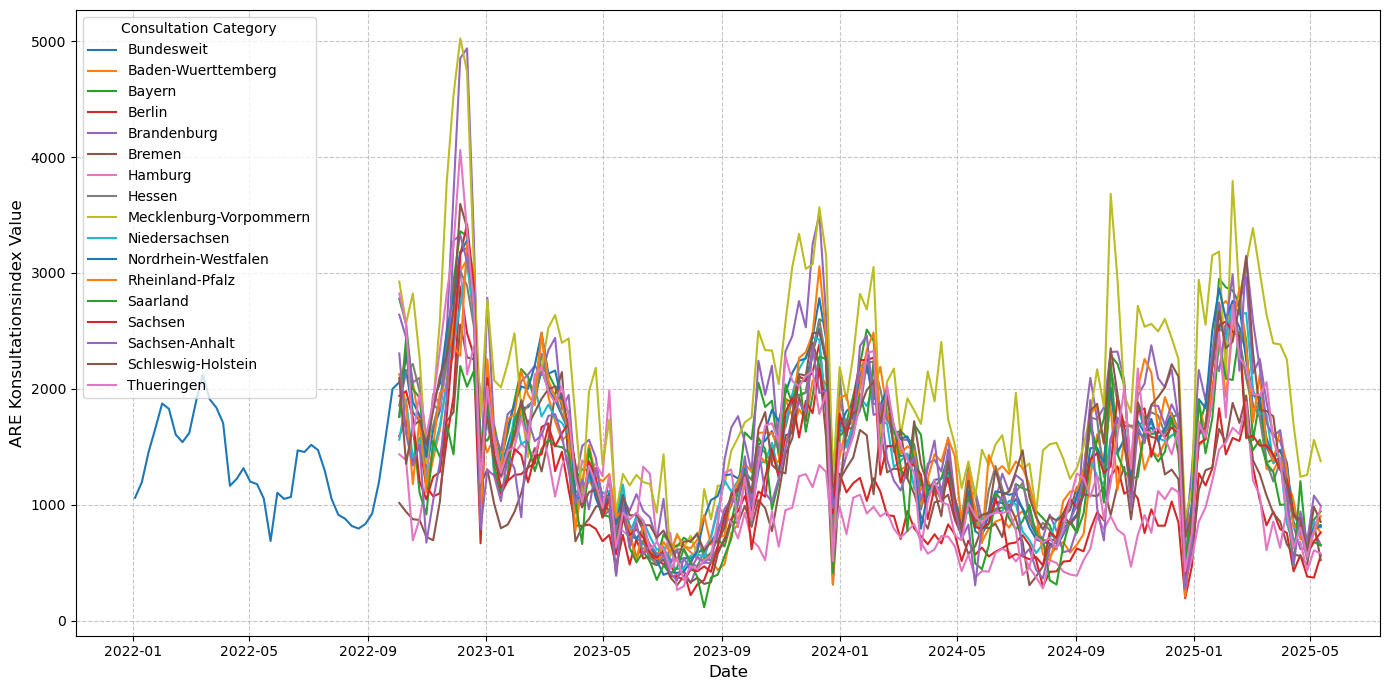

In [65]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_daily, x='Date', y='ARE_konsul_00+', hue='Bundesland', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.ylabel('ARE Konsultationsindex Value', fontsize=12)
plt.legend(title='Consultation Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [66]:
df_interpol = df_daily.copy()

df_interpol.interpolate(method='linear', limit_direction='forward', inplace=True)

/tmp/ipykernel_17263/287348452.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpol.interpolate(method='linear', limit_direction='forward', inplace=True)


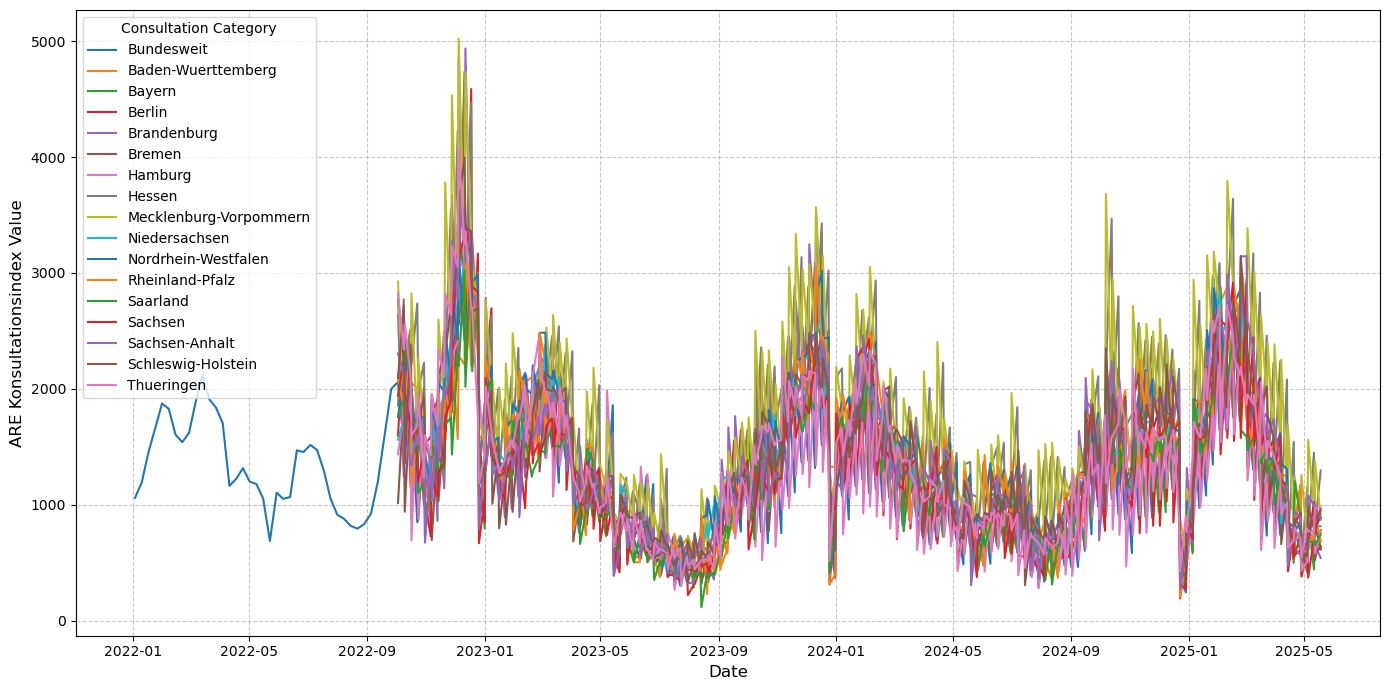

In [67]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_interpol, x='Date', y='ARE_konsul_00+', hue='Bundesland', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.ylabel('ARE Konsultationsindex Value', fontsize=12)
plt.legend(title='Consultation Category')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

***
### Grippeweb

In [29]:
df_grippeweb_orig = pd.read_csv('../data/GrippeWeb_Daten_des_Wochenberichts.tsv', sep='\t')

In [30]:
df_grippeweb_orig.drop(columns=["Saison", 'Meldungen'], inplace=True)

In [38]:
df_agegrps = df_grippeweb_orig.pivot_table(
    index=["Kalenderwoche", "Region"],
    columns=['Erkrankung', 'Altersgruppe'],
    values='Inzidenz'
).reset_index()
df_agegrps.columns = [f"grippeweb_{col}" if col != 'Kalenderwoche' and col != 'Region' else col for col in df_agegrps.columns]
df_agegrps.columns = [col.replace("('", "").replace("', '", "_").replace("')", "") for col in df_agegrps.columns]
df_agegrps.columns = [col.rstrip("_") for col in df_agegrps.columns]

In [39]:
df_agegrps

,grippeweb_Kalenderwoche,grippeweb_Region,grippeweb_ARE_0-14,grippeweb_ARE_0-4,grippeweb_ARE_00+,grippeweb_ARE_15+,grippeweb_ARE_15-34,grippeweb_ARE_35-59,grippeweb_ARE_5-14,grippeweb_ARE_60+,grippeweb_ILI_0-14,grippeweb_ILI_0-4,grippeweb_ILI_00+,grippeweb_ILI_15+,grippeweb_ILI_15-34,grippeweb_ILI_35-59,grippeweb_ILI_5-14,grippeweb_ILI_60+
0,2011-W22,Bundesweit,12218.0,28065.0,6927.0,6142.0,8622.0,5855.0,5267.0,4153.0,4602.0,12844.0,1715.0,1286.0,1498.0,1939.0,987.0,0.0
1,2011-W22,Mitte (West),NaN,NaN,7370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1245.0,NaN,NaN,NaN,NaN,NaN
2,2011-W22,Norden (West),NaN,NaN,9358.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,609.0,NaN,NaN,NaN,NaN,NaN
3,2011-W22,Osten,NaN,NaN,5331.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2410.0,NaN,NaN,NaN,NaN,NaN
4,2011-W22,Sueden,NaN,NaN,7364.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2104.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,2025-W20,Bundesweit,11466.0,15364.0,5281.0,4288.0,6669.0,4381.0,9672.0,2321.0,2755.0,4322.0,789.0,474.0,532.0,493.0,2034.0,406.0
3641,2025-W20,Mitte (West),NaN,NaN,4302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,686.0,NaN,NaN,NaN,NaN,NaN
3642,2025-W20,Norden (West),NaN,NaN,5507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,891.0,NaN,NaN,NaN,NaN,NaN
3643,2025-W20,Osten,NaN,NaN,6802.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.0,NaN,NaN,NaN,NaN,NaN


In [32]:
df_agegrps = df_agegrps[df_agegrps["Kalenderwoche"].str[:4].astype(int) >= 2022]

In [127]:
df_daily = df_agegrps.copy()

df_daily['Kalenderwoche'] = pd.to_datetime(df_daily['Kalenderwoche'].apply(lambda x: f'{x[:4]}-{x[5:]}-1'), format='%G-W%V-%u')

# writes all days of the week into a new date column and inserts new rows by exploding
df_daily['Date'] = df_daily.apply(lambda row: pd.date_range(row['Kalenderwoche'], row['Kalenderwoche'] + pd.Timedelta(days=6)), axis=1)
df_daily = df_daily.explode('Date')

# added rows keep the index of the row from which they exploded from. grp'ed by them we fill in nans instead of copying values
cols_to_nan = [col for col in df_daily.columns if col not in ['Date', 'Bundesland']]
df_daily[cols_to_nan] = df_daily.groupby(level=0)[cols_to_nan].transform(lambda x: [x.iloc[0]] + [np.nan]*(len(x)-1))

df_daily.drop(columns=['Kalenderwoche'], inplace=True)  

df_daily = df_daily.reset_index(drop=True)

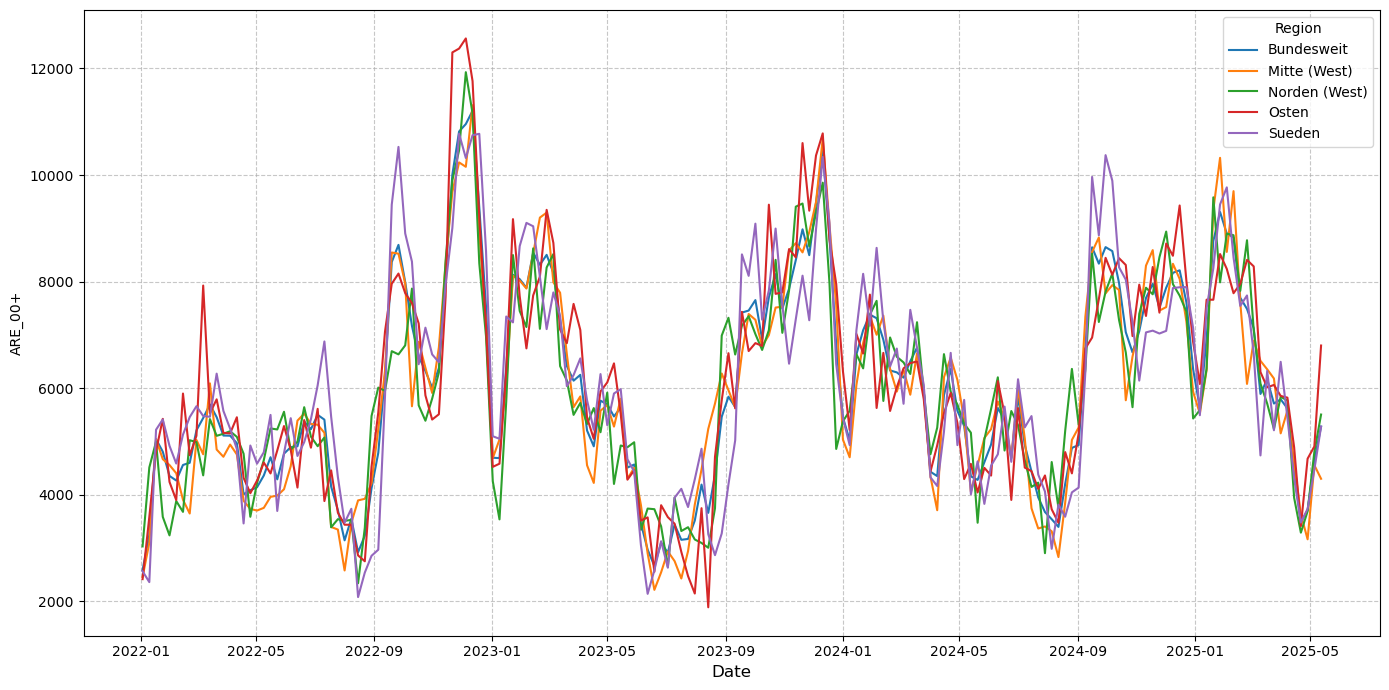

In [129]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_daily, x='Date', y='ARE_00+', hue='Region', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [130]:
df_interpol = df_daily.copy()

df_interpol.interpolate(method='linear', limit_direction='forward', inplace=True)

/tmp/ipykernel_17263/287348452.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpol.interpolate(method='linear', limit_direction='forward', inplace=True)


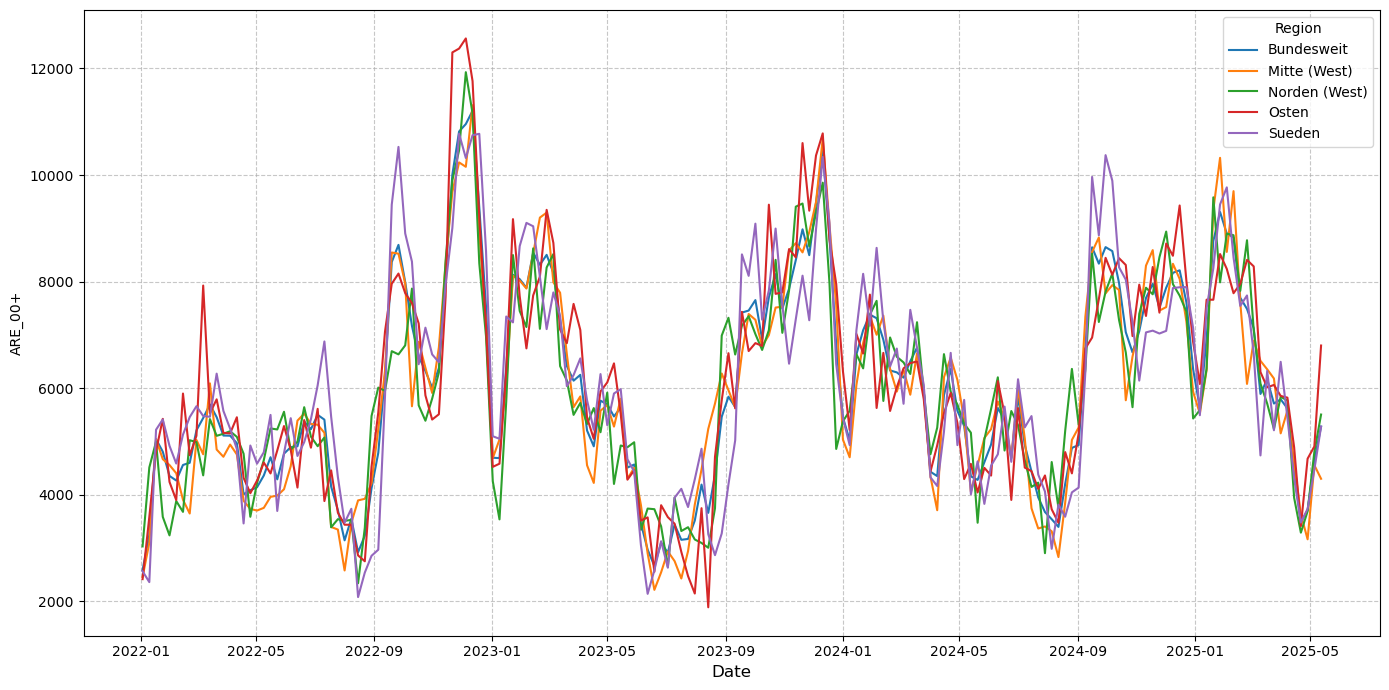

In [131]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_interpol, x='Date', y='ARE_00+', hue='Region', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

***
### covid are konsulindex

In [136]:
df_c19arekonsul_orig = pd.read_csv('../data/COVID-ARE-Konsultationsinzidenz.csv', sep=',')

In [142]:
df_agegrps = df_c19arekonsul_orig.pivot_table(
    index='date',
    columns='agegroup',
    values='are_covid19_incidence'
).reset_index()
df_agegrps.columns = [f"c19-are-konsul_{col}" if col != 'date' else col for col in df_agegrps.columns]

In [145]:
df_agegrps = df_agegrps[df_agegrps["date"].str[:4].astype(int) >= 2022]

In [151]:
df_daily = df_agegrps.copy()

df_daily['date'] = pd.to_datetime(df_daily['date'].apply(lambda x: f'{x[:4]}-{x[5:]}-1'), format='%G-W%V-%u')

# writes all days of the week into a new date column and inserts new rows by exploding
df_daily['Date'] = df_daily.apply(lambda row: pd.date_range(row['date'], row['date'] + pd.Timedelta(days=6)), axis=1)
df_daily = df_daily.explode('Date')

# added rows keep the index of the row from which they exploded from. grp'ed by them we fill in nans instead of copying values
cols_to_nan = [col for col in df_daily.columns if col not in ['Date', 'Bundesland']]
df_daily[cols_to_nan] = df_daily.groupby(level=0)[cols_to_nan].transform(lambda x: [x.iloc[0]] + [np.nan]*(len(x)-1))

df_daily.drop(columns=['date'], inplace=True)  

df_daily = df_daily.reset_index(drop=True)

In [152]:
df_daily

,c19-are-konsul_00+,c19-are-konsul_00-04,c19-are-konsul_05-14,c19-are-konsul_15-34,c19-are-konsul_35-59,c19-are-konsul_60+,Date
0,193.0,83.0,136.0,340.0,244.0,57.0,2022-01-03
1,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-04
2,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-05
3,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-06
4,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-07
...,...,...,...,...,...,...,...
1227,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-14
1228,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-15
1229,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-16
1230,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-17


/tmp/ipykernel_17263/911998194.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_daily, x='Date', y='c19-are-konsul_00+', palette='tab10')


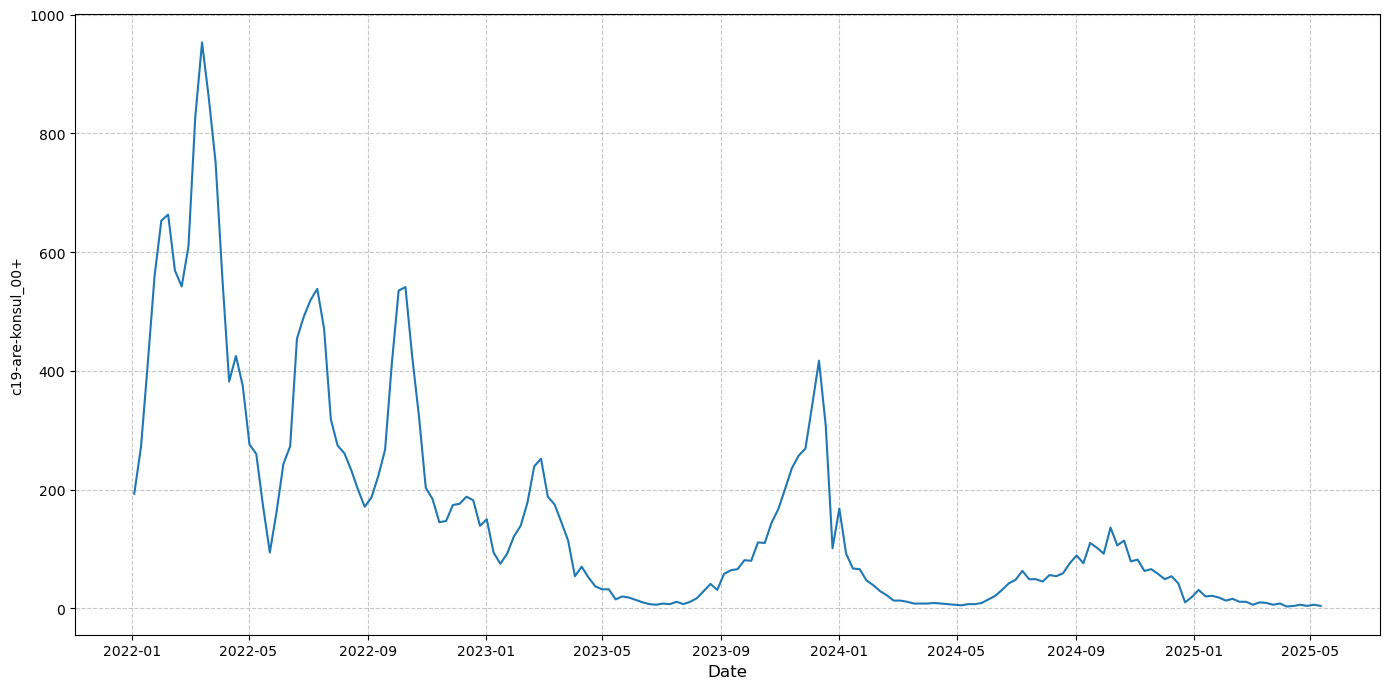

In [154]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_daily, x='Date', y='c19-are-konsul_00+', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

***
### ifsg influenza

In [170]:
df_flu_orig = pd.read_csv('../data/IfSG_Influenzafaelle.tsv', sep='\t')

In [171]:
df_flu_orig.drop(columns=["Region_Id", 'Fallzahl'], inplace=True)

In [ ]:
df_c19arekonsul_orig

,date,agegroup,are_covid19_incidence
0,2020-W40,00+,14
1,2020-W40,00-04,8
2,2020-W40,05-14,17
3,2020-W40,15-34,22
4,2020-W40,35-59,13
...,...,...,...
1447,2025-W20,00-04,0
1448,2025-W20,05-14,1
1449,2025-W20,15-34,8
1450,2025-W20,35-59,5


In [172]:
df_agegrps = df_flu_orig.pivot_table(
    index='Meldewoche',
    columns='Altersgruppe',
    values='Inzidenz'
).reset_index()
df_agegrps.columns = [f"ifsg-flu_{col}" if col != 'Meldewoche' else col for col in df_agegrps.columns]

In [175]:
df_agegrps = df_agegrps[df_agegrps["Meldewoche"].str[:4].astype(int) >= 2022]

In [176]:
df_daily = df_agegrps.copy()

df_daily['Meldewoche'] = pd.to_datetime(df_daily['Meldewoche'].apply(lambda x: f'{x[:4]}-{x[5:]}-1'), format='%G-W%V-%u')

# writes all days of the week into a new date column and inserts new rows by exploding
df_daily['Date'] = df_daily.apply(lambda row: pd.date_range(row['Meldewoche'], row['Meldewoche'] + pd.Timedelta(days=6)), axis=1)
df_daily = df_daily.explode('Date')

# added rows keep the index of the row from which they exploded from. grp'ed by them we fill in nans instead of copying values
cols_to_nan = [col for col in df_daily.columns if col not in ['Date', 'Bundesland']]
df_daily[cols_to_nan] = df_daily.groupby(level=0)[cols_to_nan].transform(lambda x: [x.iloc[0]] + [np.nan]*(len(x)-1))

df_daily.drop(columns=['Meldewoche'], inplace=True)  

df_daily = df_daily.reset_index(drop=True)

/tmp/ipykernel_17263/3850549138.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_daily, x='Date', y='ifsg-flu_00+', palette='tab10')


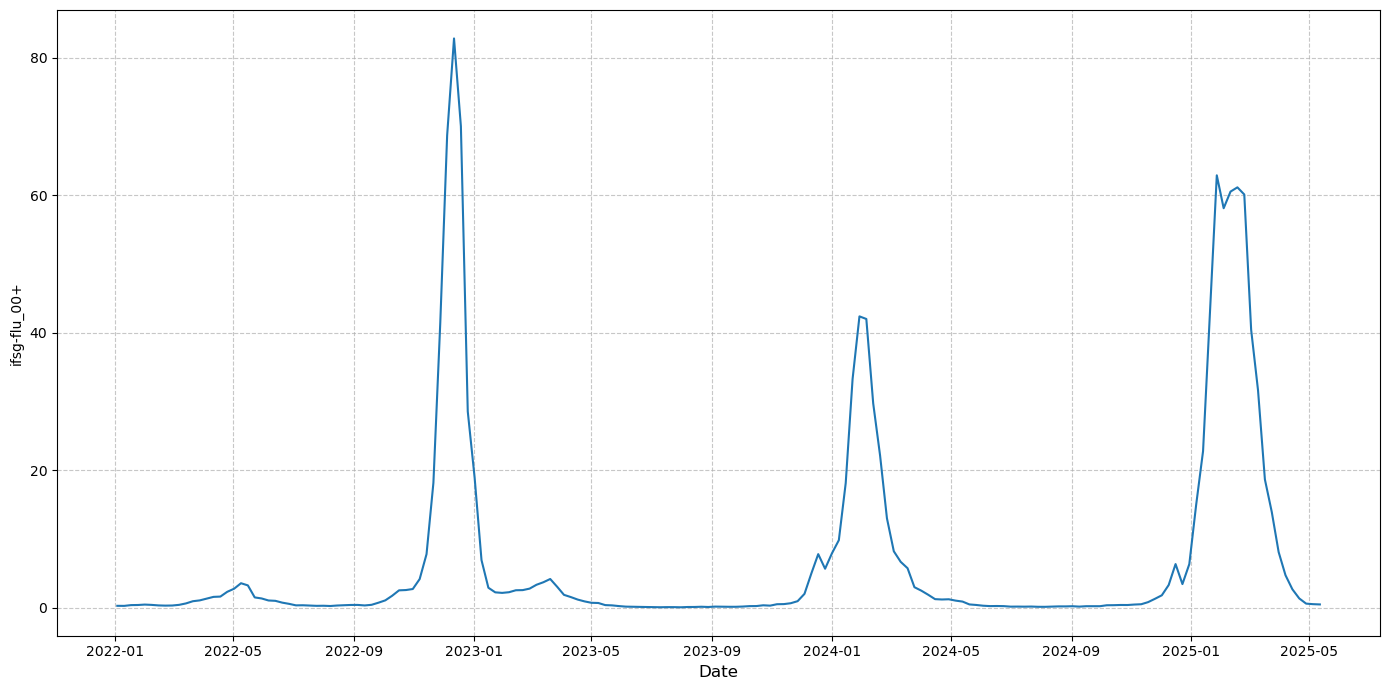

In [177]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_daily, x='Date', y='ifsg-flu_00+', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [178]:
df_interpol = df_daily.copy()

df_interpol.interpolate(method='linear', limit_direction='forward', inplace=True)

/tmp/ipykernel_17263/3319438547.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_interpol, x='Date', y='ifsg-flu_00+', palette='tab10')


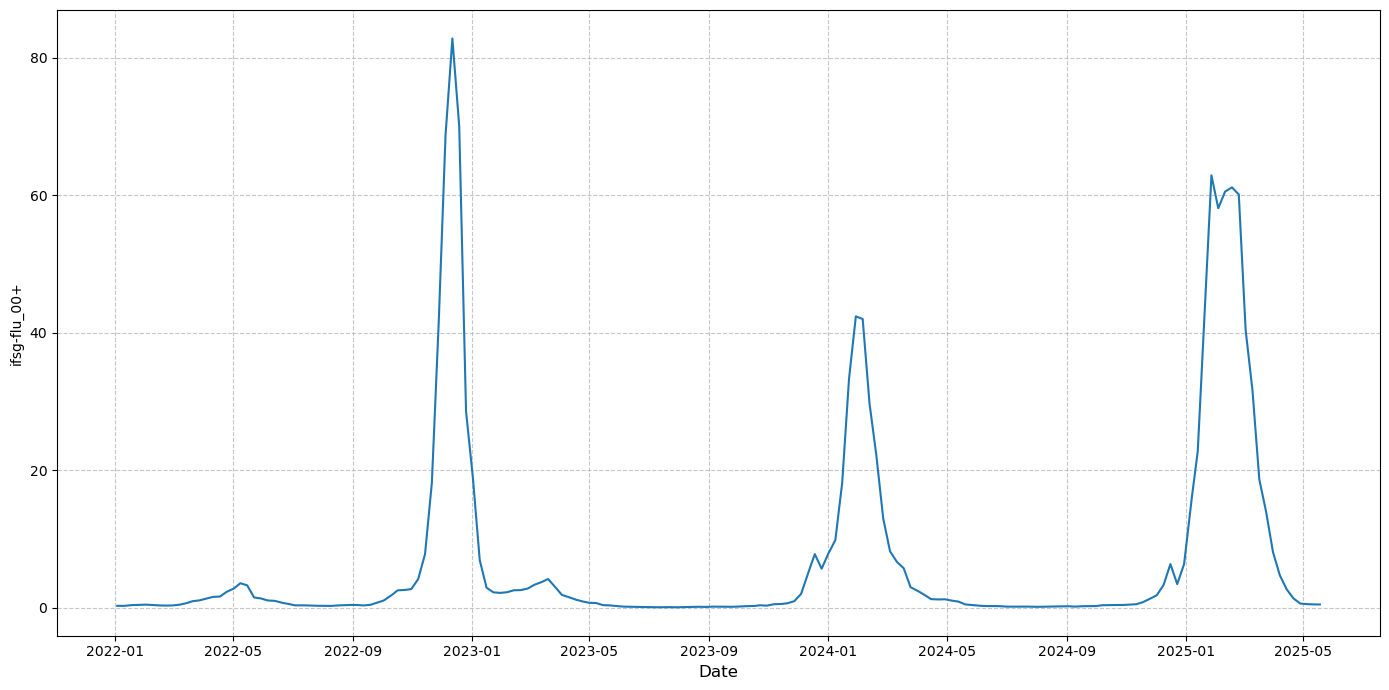

In [179]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_interpol, x='Date', y='ifsg-flu_00+', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

***
### intensivregister

In [3]:
df_icureg_orig = pd.read_csv('../data/Intensivregister_Bundeslaender_Kapazitaeten.csv', sep=',')

In [4]:
val_col = [
    'datum',
    'bundesland_name',
    'faelle_covid_aktuell',
    'faelle_covid_erstaufnahmen'
]

In [12]:
df_icureg_orig.drop(columns=[col for col in df_icureg_orig.columns if col not in val_col], inplace=True)

df_daily = df_icureg_orig[df_icureg_orig["datum"].str[:4].astype(int) >= 2022]

/tmp/ipykernel_27312/2703381881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icureg_orig.drop(columns=[col for col in df_icureg_orig.columns if col not in val_col], inplace=True)


In [13]:
df_daily

,datum,bundesland_name,faelle_covid_aktuell,faelle_covid_erstaufnahmen
10432,2022-01-01,Schleswig-Holstein,57,3.0
10433,2022-01-01,Hamburg,73,4.0
10434,2022-01-01,Niedersachsen,197,12.0
10435,2022-01-01,Bremen,24,1.0
10436,2022-01-01,Nordrhein-Westfalen,580,25.0
...,...,...,...,...
30235,2025-05-22,Brandenburg,0,NaN
30236,2025-05-22,Mecklenburg-Vorpommern,0,NaN
30237,2025-05-22,Sachsen,0,NaN
30238,2025-05-22,Sachsen-Anhalt,0,NaN


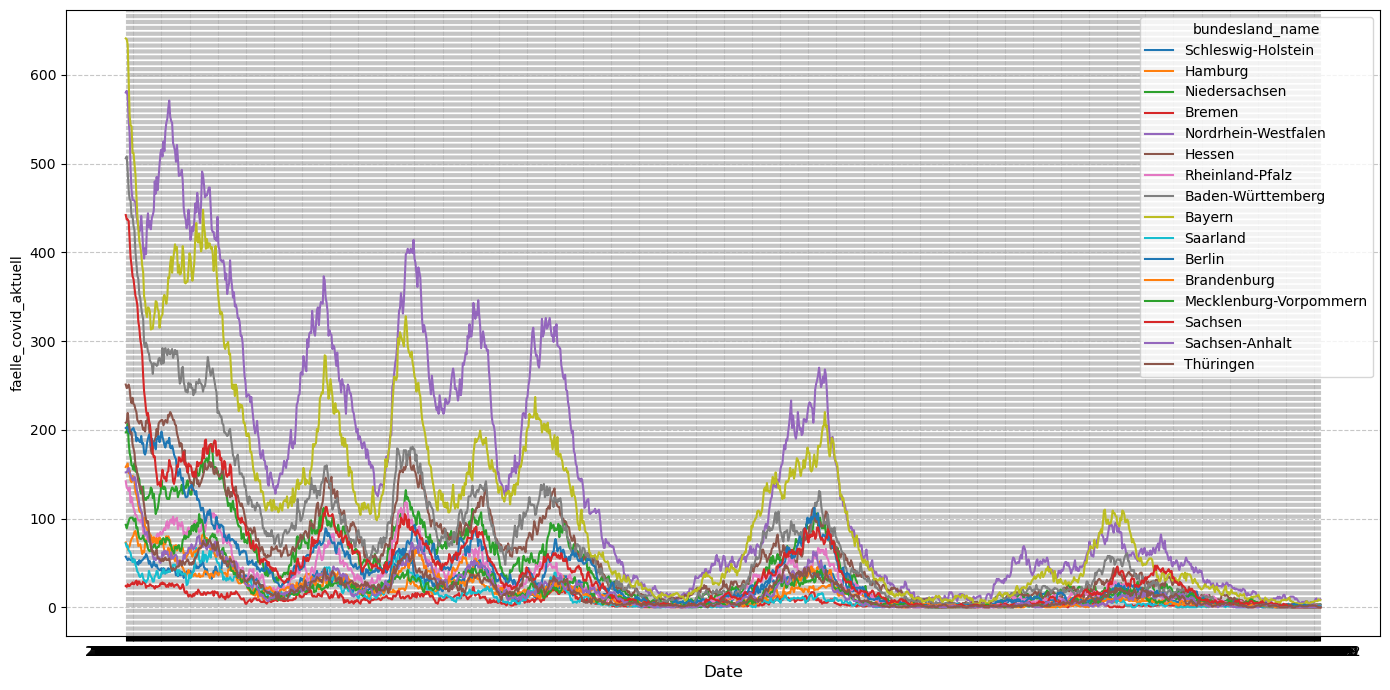

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_daily, x='datum', y='faelle_covid_aktuell', hue='bundesland_name', palette='tab10')

plt.xlabel('Date', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

***
### notaufnahme surveillance

In [14]:
df_nas_orig = pd.read_csv('../data/Notaufnahmesurveillance_Zeitreihen_Syndrome.tsv', sep='\t')

In [18]:
df_nas_orig.drop(columns=["ed_type", 'ed_count'], inplace=True)

In [19]:
df_nas_orig

,date,age_group,syndrome,relative_cases,relative_cases_7day_ma,expected_value,expected_lowerbound,expected_upperbound
0,2019-01-01,0-4,ARI,28.814,NaN,24.864967,20.773146,29.194938
1,2019-01-02,0-4,ARI,27.273,NaN,24.860944,20.769490,29.190546
2,2019-01-03,0-4,ARI,26.786,NaN,24.854109,20.763260,29.183102
3,2019-01-04,0-4,ARI,24.444,NaN,24.844465,20.754462,29.172609
4,2019-01-05,0-4,ARI,16.667,NaN,24.832019,20.743101,29.159074
...,...,...,...,...,...,...,...,...
240890,2025-05-17,80+,COVID,0.000,0.0,NaN,NaN,NaN
240891,2025-05-18,80+,COVID,0.000,0.0,NaN,NaN,NaN
240892,2025-05-19,80+,COVID,0.000,0.0,NaN,NaN,NaN
240893,2025-05-20,80+,COVID,0.000,0.0,NaN,NaN,NaN


In [36]:
df_agegrps = df_nas_orig.pivot_table(
    index='date',
    columns=['age_group', 'syndrome'],
    values=['relative_cases', 'relative_cases_7day_ma', 'expected_value', 'expected_lowerbound', 'expected_upperbound']
).reset_index()
df_agegrps.columns = [f"nas-reg_{col}" if col != 'date' else col for col in df_agegrps.columns]

df_agegrps.columns = [col.replace("('", "").replace("', '", "_").replace("')", "") for col in df_agegrps.columns]

df_agegrps.columns = [col.rstrip("_") for col in df_agegrps.columns]

In [37]:
df_agegrps

,nas-reg_date,nas-reg_expected_lowerbound_0-4_ARI,nas-reg_expected_lowerbound_0-4_GI,nas-reg_expected_lowerbound_0-4_ILI,nas-reg_expected_lowerbound_0-4_SARI,nas-reg_expected_lowerbound_00+_ARI,nas-reg_expected_lowerbound_00+_GI,nas-reg_expected_lowerbound_00+_ILI,nas-reg_expected_lowerbound_00+_SARI,nas-reg_expected_lowerbound_10-14_ARI,...,nas-reg_relative_cases_7day_ma_60-79_ARI,nas-reg_relative_cases_7day_ma_60-79_COVID,nas-reg_relative_cases_7day_ma_60-79_GI,nas-reg_relative_cases_7day_ma_60-79_ILI,nas-reg_relative_cases_7day_ma_60-79_SARI,nas-reg_relative_cases_7day_ma_80+_ARI,nas-reg_relative_cases_7day_ma_80+_COVID,nas-reg_relative_cases_7day_ma_80+_GI,nas-reg_relative_cases_7day_ma_80+_ILI,nas-reg_relative_cases_7day_ma_80+_SARI
0,2019-01-01,20.237599,4.207533,0.429126,1.799343,6.595632,1.185331,0.050128,1.112963,3.182734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,20.233757,4.210094,0.441471,1.794014,6.611516,1.186598,0.052905,1.116631,3.190609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,20.227369,4.212602,0.453615,1.788248,6.626814,1.187849,0.055650,1.120123,3.198064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,20.218441,4.215057,0.465530,1.782049,6.641516,1.189083,0.058355,1.123435,3.205094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-05,20.206977,4.217457,0.477188,1.775424,6.655616,1.190301,0.061010,1.126566,3.211694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,2025-05-17,11.242009,4.959560,0.000000,0.433703,6.360680,2.682707,0.000000,0.419386,2.757570,...,5.524857,0.022286,1.792714,0.050571,1.825857,6.025000,0.0,1.738143,0.038714,2.120000
2329,2025-05-18,11.188868,4.954227,0.000000,0.428308,6.329708,2.678362,0.000000,0.414446,2.742281,...,5.654143,0.022286,1.586714,0.050571,1.756286,5.685286,0.0,1.783714,0.038714,1.848714
2330,2025-05-19,11.136951,4.948803,0.000000,0.423087,6.299255,2.673959,0.000000,0.409615,2.727184,...,5.795286,0.022286,1.674143,0.093000,1.754286,5.874571,0.0,1.927857,0.038714,1.904000
2331,2025-05-20,11.086259,4.943289,0.000000,0.418035,6.269324,2.669502,0.000000,0.404892,2.712281,...,5.852857,0.022286,1.758714,0.096000,1.583714,5.736571,0.0,1.961857,0.038714,1.782286


***
## Meterological Data